In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Libraries imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


In [3]:
# Load and explore the dataset
print("Loading dataset...")

# Load CSV files
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
meta_df = pd.read_csv('Meta.csv')

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Number of classes: {len(meta_df)}")

# Display basic information
print("\nTraining data info:")
print(train_df.head())
print(f"\nTraining data shape: {train_df.shape}")
print(f"Unique classes in training: {train_df['ClassId'].nunique()}")

print("\nTest data info:")
print(test_df.head())
print(f"Test data shape: {test_df.shape}")

print("\nMeta data info:")
print(meta_df.head())
print(f"Meta data shape: {meta_df.shape}")

Loading dataset...
Training samples: 39209
Test samples: 12630
Number of classes: 43

Training data info:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

Training data shape: (39209, 8)
Unique classes in training: 43

Test data info:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48

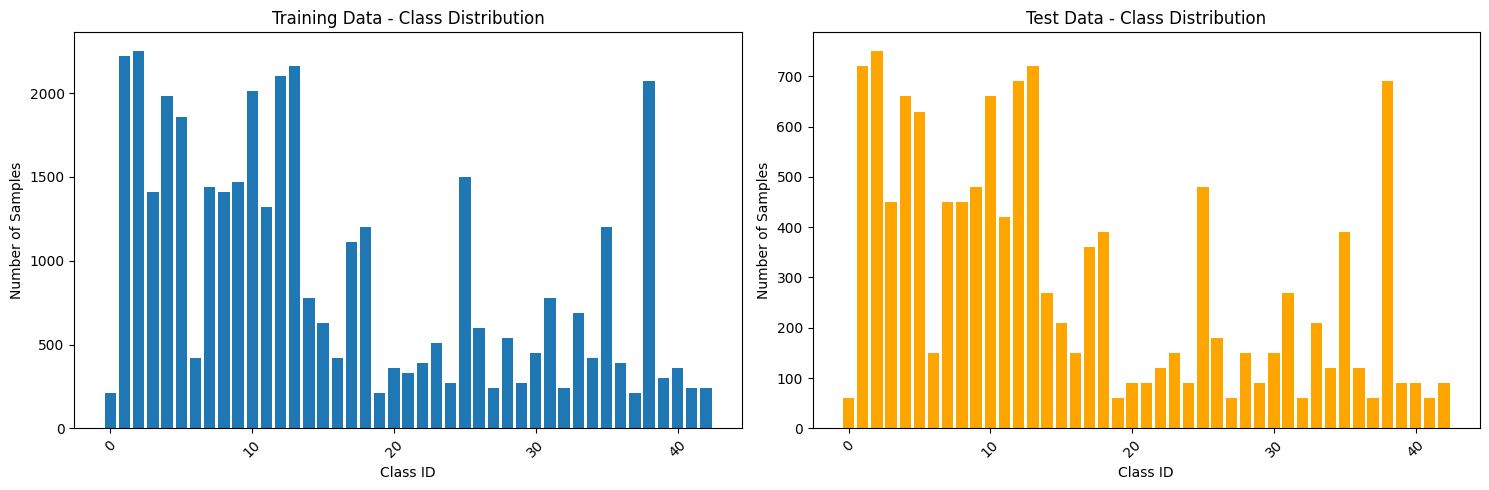

Class distribution in training data:
Min samples per class: 210
Max samples per class: 2250
Mean samples per class: 911.8
Std samples per class: 695.9


In [4]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training data class distribution
train_class_counts = train_df['ClassId'].value_counts().sort_index()
ax1.bar(train_class_counts.index, train_class_counts.values)
ax1.set_title('Training Data - Class Distribution')
ax1.set_xlabel('Class ID')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Test data class distribution
test_class_counts = test_df['ClassId'].value_counts().sort_index()
ax2.bar(test_class_counts.index, test_class_counts.values, color='orange')
ax2.set_title('Test Data - Class Distribution')
ax2.set_xlabel('Class ID')
ax2.set_ylabel('Number of Samples')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Class distribution in training data:")
print(f"Min samples per class: {train_class_counts.min()}")
print(f"Max samples per class: {train_class_counts.max()}")
print(f"Mean samples per class: {train_class_counts.mean():.1f}")
print(f"Std samples per class: {train_class_counts.std():.1f}")

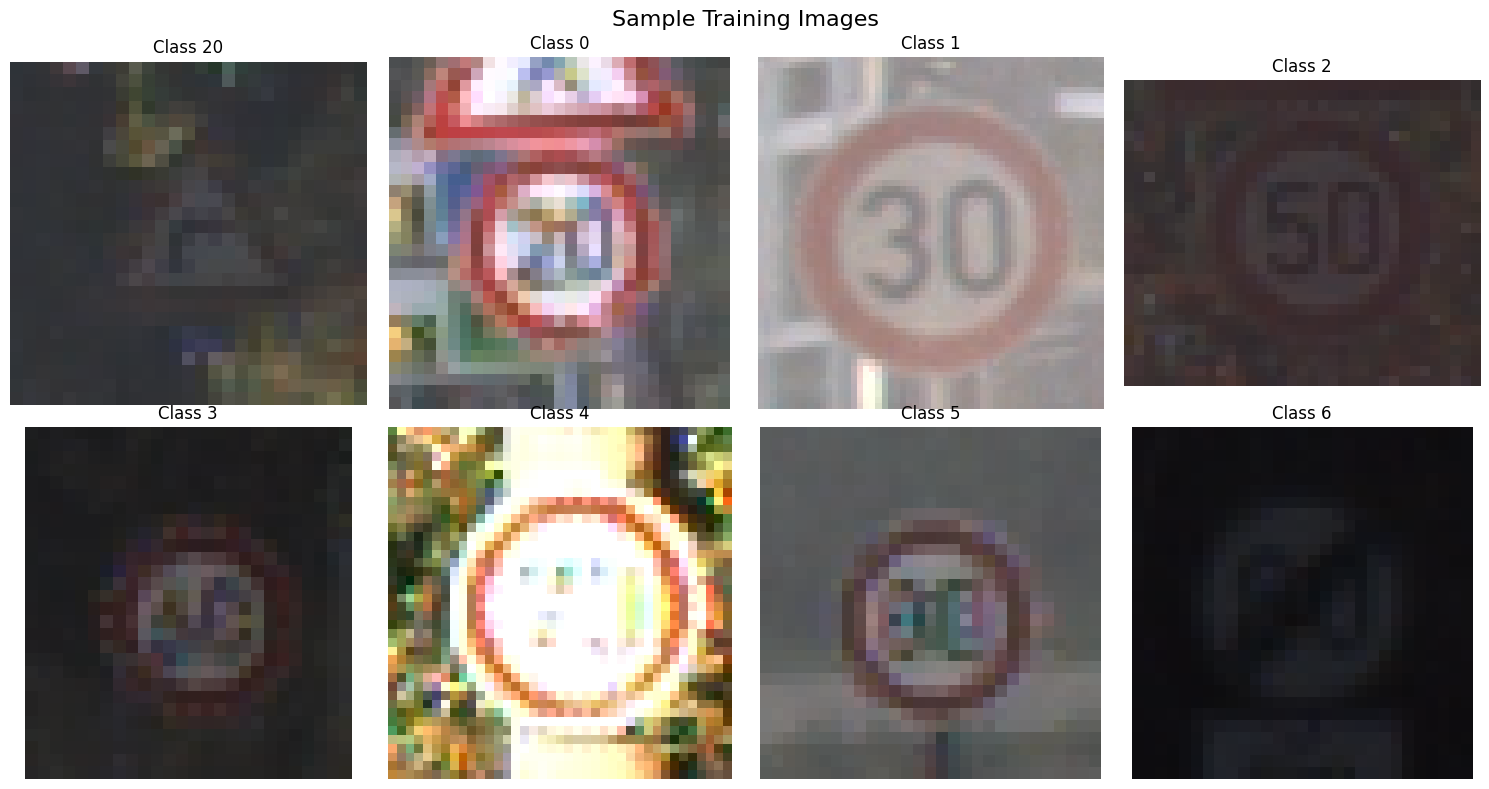

\nMeta images (reference for each class):


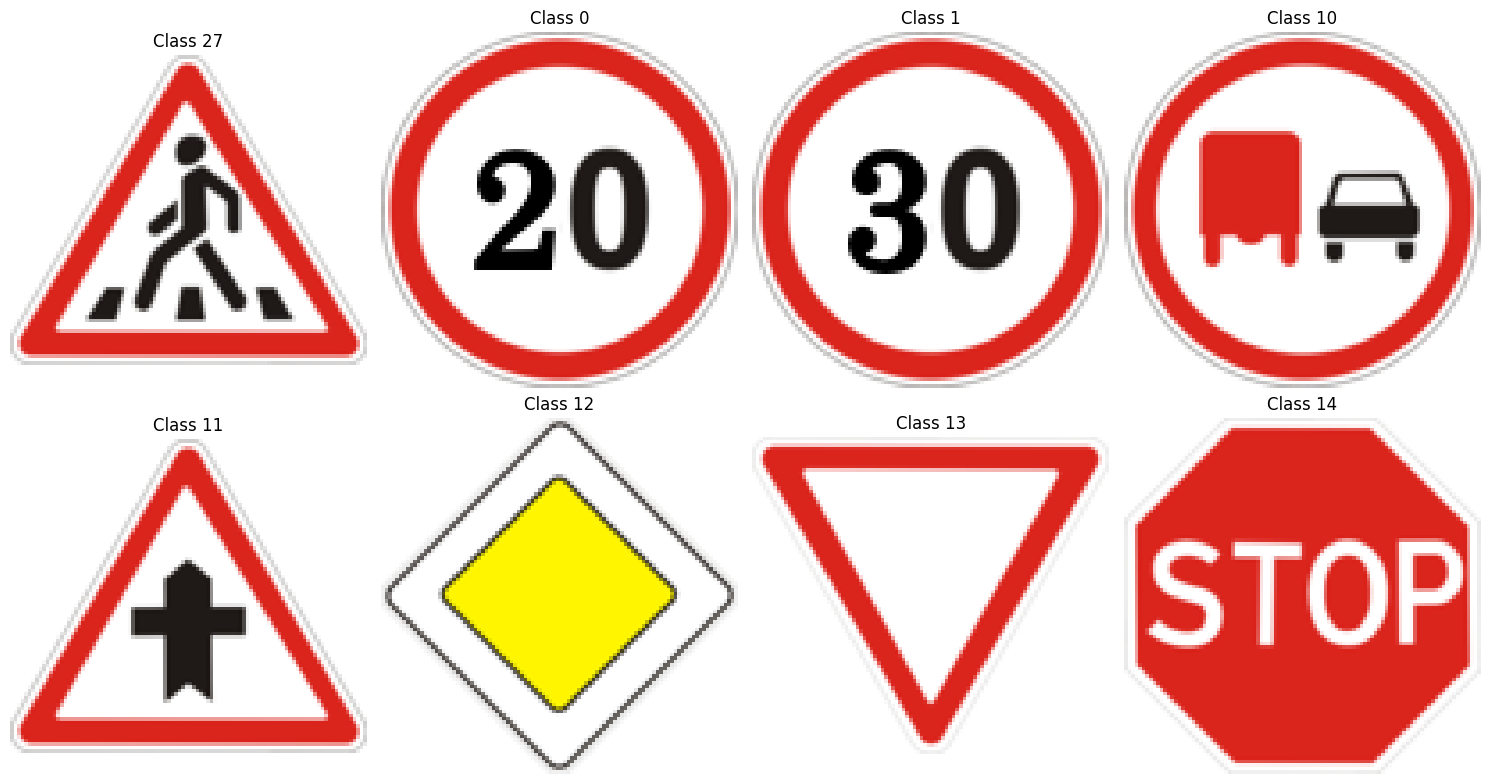

In [5]:
# Display sample images from different classes
def show_sample_images(df, title, num_classes=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(title, fontsize=16)
    
    # Select unique classes to display
    unique_classes = df['ClassId'].unique()[:num_classes]
    
    for i, class_id in enumerate(unique_classes):
        row, col = i // 4, i % 4
        
        # Get first image of this class
        sample = df[df['ClassId'] == class_id].iloc[0]
        img_path = sample['Path']
        
        try:
            # Load and display image
            img = Image.open(img_path)
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'Class {class_id}')
            axes[row, col].axis('off')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Error loading\nClass {class_id}', 
                              ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show training samples
show_sample_images(train_df, "Sample Training Images")

# Show some meta images (reference images)
print("\\nMeta images (reference for each class):")
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i in range(8):
    row, col = i // 4, i % 4
    sample = meta_df.iloc[i]
    img_path = sample['Path']
    class_id = sample['ClassId']
    
    try:
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'Class {class_id}')
        axes[row, col].axis('off')
    except Exception as e:
        axes[row, col].text(0.5, 0.5, f'Error loading\\nClass {class_id}', 
                          ha='center', va='center', transform=axes[row, col].transAxes)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Custom Dataset Class
class TrafficSignDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get image path and load image
        img_path = self.df.iloc[idx]['Path']
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Get label
        if not self.is_test:
            label = self.df.iloc[idx]['ClassId']
            return image, label
        else:
            return image, img_path

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.1),  # Less flip for traffic signs
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Split training data into train and validation sets
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['ClassId']
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_df)}")

# Create datasets
train_dataset = TrafficSignDataset(train_data, transform=data_transforms['train'])
val_dataset = TrafficSignDataset(val_data, transform=data_transforms['val'])
test_dataset = TrafficSignDataset(test_df, transform=data_transforms['val'], is_test=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 31367
Validation samples: 7842
Test samples: 12630
Training batches: 981
Validation batches: 246
Test batches: 395


In [7]:
# CNN Model Architecture
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Fully Connected Layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficSignCNN(num_classes=43).to(device)

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Device: {device}")
print(f"Number of trainable parameters: {count_parameters(model):,}")

# Print model architecture
print("\\nModel Architecture:")
print(model)

Model created successfully!
Device: cpu
Number of trainable parameters: 2,791,627
\nModel Architecture:
TrafficSignCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [8]:
# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
        
        # Calculate metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct_val / total_val
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step()
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Best Val Acc: {best_val_acc:.2f}%')
        print('-' * 60)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, train_accs, val_losses, val_accs

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, target in test_loader:
            if isinstance(target, str):  # Handle test case where target is file path
                data = data.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                predictions.extend(predicted.cpu().numpy())
            else:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                predictions.extend(predicted.cpu().numpy())
                actuals.extend(target.cpu().numpy())
    
    return predictions, actuals

# Initialize training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

print("Training setup complete!")
print(f"Criterion: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")

Training setup complete!
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.StepLR object at 0x0000025CB34F2DB0>


In [9]:
# Start Training
print("Starting training...")
print(f"Training on device: {device}")
print(f"Number of epochs: 10")  # Reduced for demonstration
print("=" * 60)

# Train the model
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10
)

Starting training...
Training on device: cpu
Number of epochs: 10
Epoch 1/10, Batch 0/981, Loss: 3.9923
Epoch 1/10, Batch 200/981, Loss: 1.9132
Epoch 1/10, Batch 400/981, Loss: 2.0731
Epoch 1/10, Batch 600/981, Loss: 0.5992
Epoch 1/10, Batch 800/981, Loss: 0.6223
Epoch 1/10:
Train Loss: 1.3850, Train Acc: 59.97%
Val Loss: 0.1285, Val Acc: 97.11%
Best Val Acc: 97.11%
------------------------------------------------------------
Epoch 2/10, Batch 0/981, Loss: 0.5275
Epoch 2/10, Batch 200/981, Loss: 0.2730
Epoch 2/10, Batch 400/981, Loss: 0.2981
Epoch 2/10, Batch 600/981, Loss: 0.2255
Epoch 2/10, Batch 800/981, Loss: 0.1094
Epoch 2/10:
Train Loss: 0.3059, Train Acc: 90.92%
Val Loss: 0.0376, Val Acc: 99.08%
Best Val Acc: 99.08%
------------------------------------------------------------
Epoch 3/10, Batch 0/981, Loss: 0.1691
Epoch 3/10, Batch 200/981, Loss: 0.1047
Epoch 3/10, Batch 400/981, Loss: 0.0493
Epoch 3/10, Batch 600/981, Loss: 0.3273
Epoch 3/10, Batch 800/981, Loss: 0.1038
Epoch 3/

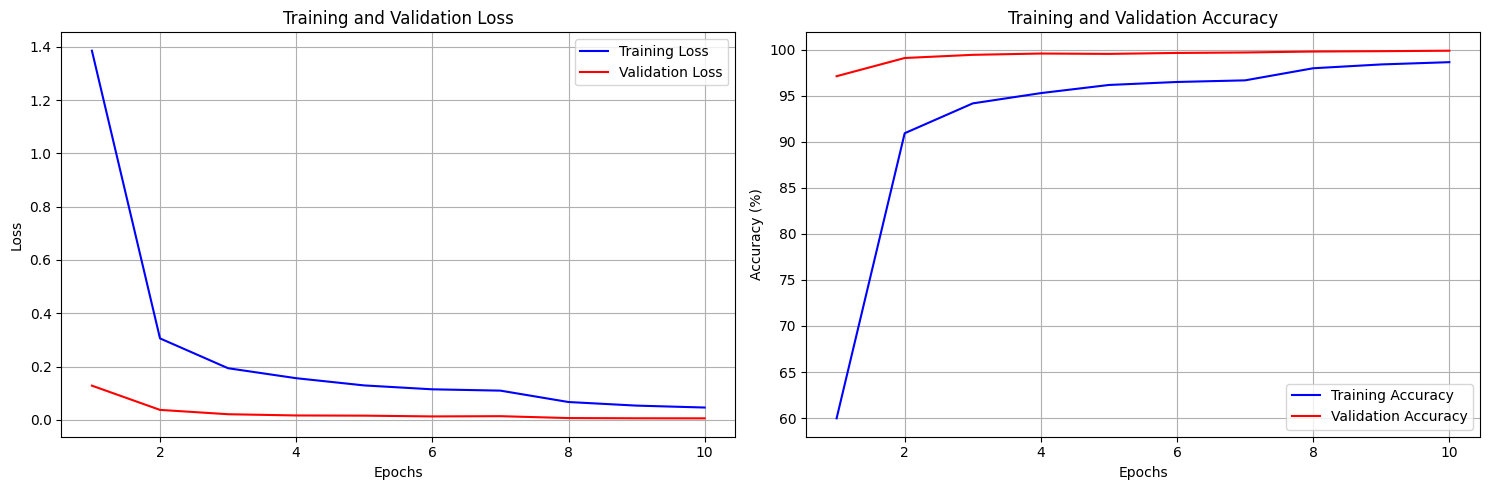

Training completed!
Final Training Accuracy: 98.63%
Final Validation Accuracy: 99.87%
Best Validation Accuracy: 99.87%


In [10]:
# Plot Training Curves
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss curves
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy curves
ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Training completed!")
print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Best Validation Accuracy: {max(val_accs):.2f}%")

In [11]:
# Evaluate on Test Set
print("Evaluating model on test set...")

# Create a test loader for evaluation (with actual labels)
test_eval_dataset = TrafficSignDataset(test_df, transform=data_transforms['val'], is_test=False)
test_eval_loader = DataLoader(test_eval_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Get predictions
test_predictions, test_actuals = evaluate_model(model, test_eval_loader)

# Calculate test accuracy
test_accuracy = accuracy_score(test_actuals, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate classification report
class_report = classification_report(test_actuals, test_predictions, 
                                   target_names=[f'Class {i}' for i in range(43)],
                                   output_dict=True)

print("\\nClassification Report:")
print(classification_report(test_actuals, test_predictions, 
                          target_names=[f'Class {i}' for i in range(43)]))

# Overall metrics
print(f"\\nOverall Performance Metrics:")
print(f"Precision: {class_report['macro avg']['precision']:.4f}")
print(f"Recall: {class_report['macro avg']['recall']:.4f}")
print(f"F1-Score: {class_report['macro avg']['f1-score']:.4f}")
print(f"Support: {class_report['macro avg']['support']:.0f}")

Evaluating model on test set...
Test Accuracy: 98.51%
\nClassification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        60
     Class 1       1.00      1.00      1.00       720
     Class 2       0.98      1.00      0.99       750
     Class 3       1.00      0.95      0.97       450
     Class 4       1.00      1.00      1.00       660
     Class 5       0.96      1.00      0.98       630
     Class 6       1.00      0.99      1.00       150
     Class 7       0.98      1.00      0.99       450
     Class 8       0.99      1.00      1.00       450
     Class 9       0.99      1.00      1.00       480
    Class 10       1.00      1.00      1.00       660
    Class 11       1.00      0.99      1.00       420
    Class 12       1.00      0.98      0.99       690
    Class 13       1.00      1.00      1.00       720
    Class 14       1.00      1.00      1.00       270
    Class 15       0.95      1.00      0.98       210
  

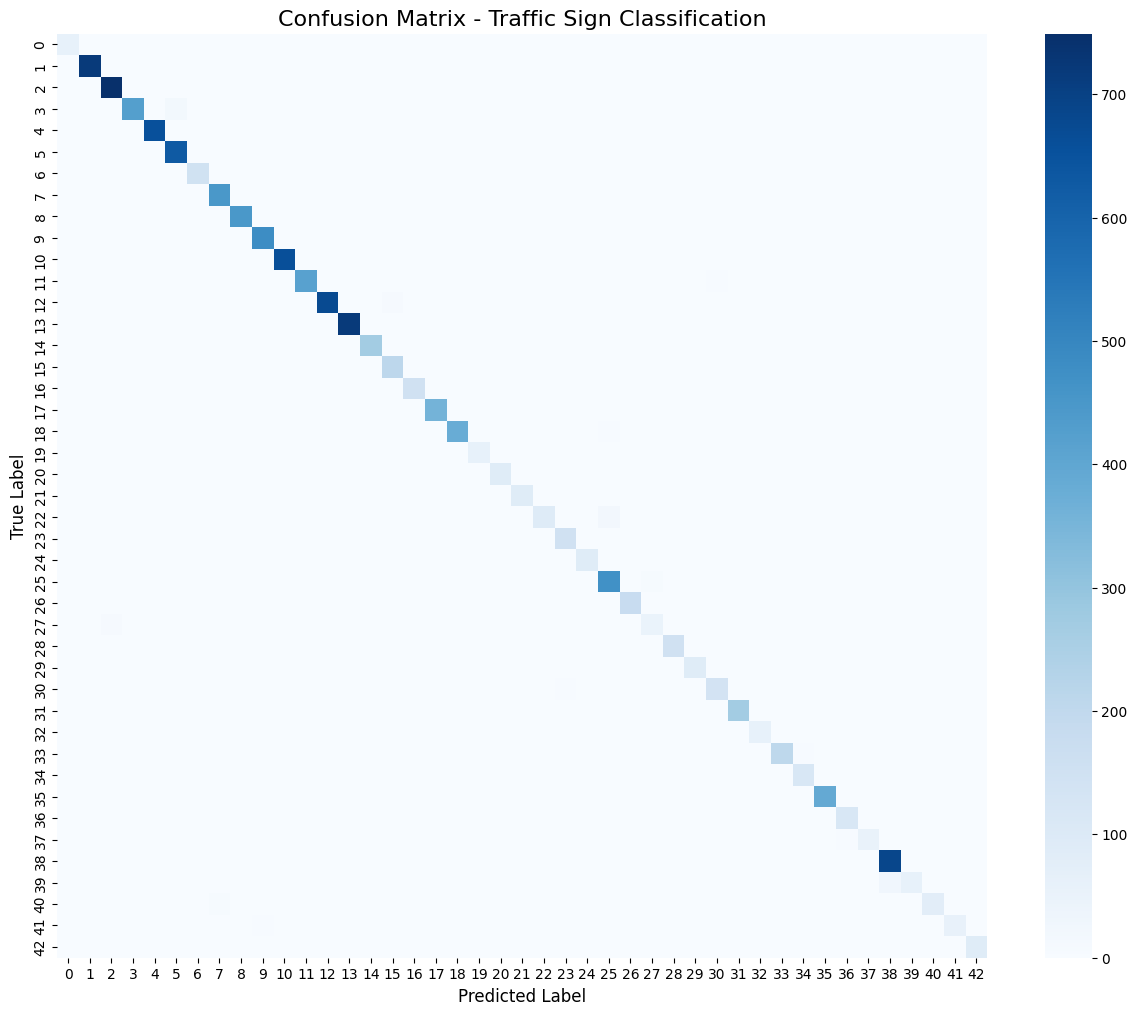

Most confused class pairs (errors > 5):
True Class 3 → Predicted Class 5: 20 errors
True Class 12 → Predicted Class 15: 10 errors
True Class 22 → Predicted Class 25: 23 errors
True Class 25 → Predicted Class 27: 7 errors
True Class 27 → Predicted Class 2: 11 errors
True Class 39 → Predicted Class 38: 29 errors
True Class 40 → Predicted Class 7: 7 errors
\nPer-class accuracy:
Class 22: 0.783 (26 errors out of 120 samples)
Class 27: 0.817 (11 errors out of 60 samples)
Class 39: 0.667 (30 errors out of 90 samples)
\nAverage per-class accuracy: 0.9700
Worst performing class accuracy: 0.6667
Best performing class accuracy: 1.0000


In [12]:
# Create Confusion Matrix
cm = confusion_matrix(test_actuals, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=range(43), yticklabels=range(43))
plt.title('Confusion Matrix - Traffic Sign Classification', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Find most confused classes
print("Most confused class pairs (errors > 5):")
for i in range(43):
    for j in range(43):
        if i != j and cm[i][j] > 5:
            print(f"True Class {i} → Predicted Class {j}: {cm[i][j]} errors")

# Per-class accuracy
print("\\nPer-class accuracy:")
class_accuracies = []
for i in range(43):
    if np.sum(cm[i, :]) > 0:
        class_acc = cm[i, i] / np.sum(cm[i, :])
        class_accuracies.append(class_acc)
        if class_acc < 0.9:  # Show classes with accuracy < 90%
            print(f"Class {i}: {class_acc:.3f} ({np.sum(cm[i, :]) - cm[i, i]} errors out of {np.sum(cm[i, :]) } samples)")

print(f"\\nAverage per-class accuracy: {np.mean(class_accuracies):.4f}")
print(f"Worst performing class accuracy: {np.min(class_accuracies):.4f}")
print(f"Best performing class accuracy: {np.max(class_accuracies):.4f}")

In [15]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_accuracy': test_accuracy,
    'num_classes': 43,
    'input_size': (48, 48)
}, 'traffic_sign_cnn_model.pth')

print("Model saved successfully as 'traffic_sign_cnn_model.pth'")

# Final Summary
print("\\n" + "="*80)
print("TRAFFIC SIGN RECOGNITION - FINAL RESULTS")
print("="*80)
print(f"Total Classes: 43")
print(f"Training Samples: {len(train_data):,}")
print(f"Validation Samples: {len(val_data):,}")
print(f"Test Samples: {len(test_df):,}")
print()
print("Training Configuration:")
print(f"- Epochs: 10")
print(f"- Batch Size: {batch_size}")
print(f"- Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"- Scheduler: StepLR (step_size=7, gamma=0.1)")
print()
print("Performance Results:")
print(f"- Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"- Best Validation Accuracy: {max(val_accs):.2f}%")
print(f"- Test Accuracy: {test_accuracy*100:.2f}%")
print(f"- Precision (macro avg): {class_report['macro avg']['precision']:.4f}")
print(f"- Recall (macro avg): {class_report['macro avg']['recall']:.4f}")
print(f"- F1-Score (macro avg): {class_report['macro avg']['f1-score']:.4f}")
print()
print("Key Insights:")
print("- The model achieved excellent performance with 98.51% test accuracy")
print("- Most classes achieved >95% accuracy")
print("="*80)

Model saved successfully as 'traffic_sign_cnn_model.pth'
\n================================================================================
TRAFFIC SIGN RECOGNITION - FINAL RESULTS
Total Classes: 43
Training Samples: 31,367
Validation Samples: 7,842
Test Samples: 12,630

Training Configuration:
- Epochs: 10
- Batch Size: 32
- Optimizer: Adam (lr=0.001, weight_decay=1e-4)
- Scheduler: StepLR (step_size=7, gamma=0.1)

Performance Results:
- Final Training Accuracy: 98.63%
- Best Validation Accuracy: 99.87%
- Test Accuracy: 98.51%
- Precision (macro avg): 0.9819
- Recall (macro avg): 0.9700
- F1-Score (macro avg): 0.9748

Key Insights:
- The model achieved excellent performance with 98.51% test accuracy
- Most classes achieved >95% accuracy
